In [94]:
% matplotlib inline

In [95]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import datetime
import time
from datetime import datetime, date

In [96]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import  SVC,  LinearSVC
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.grid_search import GridSearchCV 

### 讀取csv檔：

In [97]:
dataset = pd.read_csv('cleaned_df.csv')

In [98]:
dataset.columns

Index([u'Unnamed: 0', u'group', u'date', u'time', u'piece', u'posi', u'speed',
       u'env_temp', u'env_wet', u'T1', u'T2', u'T3', u'T4', u'T5', u'radius',
       u'category'],
      dtype='object')

### 選擇任務範圍:

In [99]:
dataset = dataset.drop(['Unnamed: 0', 'group', 'date', 'time', 'piece', 'posi',
                       ], axis = 1)

In [100]:
dataset.columns

Index([u'speed', u'env_temp', u'env_wet', u'T1', u'T2', u'T3', u'T4', u'T5',
       u'radius', u'category'],
      dtype='object')

### 切分訓練/測試資料集：

In [101]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)

In [102]:
print([X_train.shape, X_test.shape, y_train.shape, y_test.shape] )
print(y_train.value_counts())
print(y_test.value_counts())

[(1980, 8), (660, 8), (1980L,), (660L,)]
2    1076
0     458
1     446
Name: category, dtype: int64
2    364
1    154
0    142
Name: category, dtype: int64


### 前處理：

In [103]:
ss = StandardScaler()

In [104]:
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

### 1. 分類任務
### 1.1  以logistic regression作基準：

In [17]:
lr = LogisticRegression()

In [18]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
lr_y_predict = lr.predict(X_test)

### 結論：用最基本的模型做分類，準確度已 100%

In [21]:
print ('LR accuracy:', lr.score(X_test, y_test))

('LR accuracy:', 1.0)


### 1.2 測試SVM:

In [43]:
svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto',
          coef0=0.0, shrinking=True, probability=False,
          tol=0.001, cache_size=200, class_weight=None,
          verbose=False, max_iter=-1, decision_function_shape='ovr',
          random_state=None)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

In [45]:
svc.fit(X_train, y_train)
svc_val_predict = svc.predict(X_test)
#svc_val_predict
print(accuracy_score(y_test, svc_val_predict))

1.0


### 結論：用SVM做分類，準確度也是 100%

### 2. 聚類任務
### 2.1 用K-means聚類

In [144]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=23)

In [145]:
from sklearn.cluster import KMeans

In [146]:
kmeans = KMeans(n_clusters = 5)

In [147]:
kmeans.fit(X_train)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [148]:
y_pred = kmeans.predict(X_test)

In [149]:
df_y_pred = pd.DataFrame(y_pred)
df_y_pred.columns = ['digit']
df_y_pred.digit.value_counts()

2    371
3    146
0    101
4     37
1      5
Name: digit, dtype: int64

### 用adjusted rand index(ARI)評估聚類結果：

In [150]:
from sklearn import metrics
print (metrics.adjusted_rand_score(y_test, y_pred)  )
#用輪廓係數(silhouette coefficient, sc)來評估聚類效果：
#須定義凝聚度(cohesion)=a 和 分離度(separation)=b
#sc[i] = (b[i]-a[i])/max(b[i],a[i])
# 0<sc<1: 聚類效果好
#-1<sc<0: 聚類效果差

0.946617722774


### 用silhouette_score度量最適合聚類數目：

In [151]:
from sklearn.metrics import silhouette_score

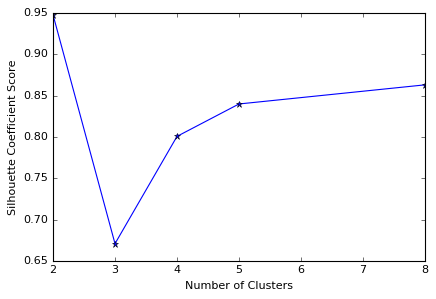

0

In [152]:
clusters = [2,3,4,5,8]
sc_scores = []
for t in clusters:
    kmeans_model = KMeans(n_clusters = t).fit(X_test)
    sc_score = silhouette_score(X_test, kmeans_model.labels_, metric='euclidean')
    sc_scores.append(sc_score)
plt.figure()
plt.plot(clusters, sc_scores, '*-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient Score')
plt.show()
#np.argmax(sc_scores)

#### 對於不同物理量構成的資料，"距離"觀念其實是有問題的（相同溫度差，濕度差，和速率差的無法比較），所以K-means不適用。

### 2.2 用t-SNE看聚類：

In [153]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)

In [154]:
X_train, X_test, y_train, y_test = train_test_split(dataset[dataset.columns[0:8]],
                     dataset[dataset.columns[9]],test_size=0.25,random_state=22)
ss_X = StandardScaler()
#ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

In [155]:
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=50, n_iter=300)
tsne_results = tsne.fit_transform(X_train)

print 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1980
[t-SNE] Computed conditional probabilities for sample 1980 / 1980
[t-SNE] Mean sigma: 0.000000
[t-SNE] Error after 100 iterations with early exaggeration: 0.539183
[t-SNE] Error after 225 iterations: 0.502974
t-SNE done! Time elapsed: 36.5599999428 seconds


In [82]:
#colors = y_train
#c = plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors, cmap=plt.cm.RdYlGn)

### 3D視覺化

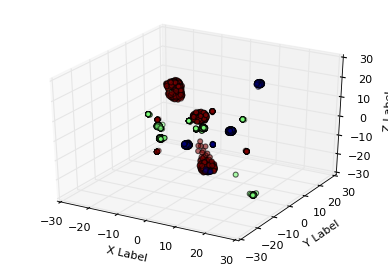

In [156]:
from mpl_toolkits.mplot3d import Axes3D as ax
import random

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:,0],tsne_results[:,1], tsne_results[:,2], s=20, c=y_train)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

### 3. 分群回歸任務

### 4. 淺層神經網路  (略過)

In [8]:
import tensorflow as tf
import numpy as np

In [108]:
sess = tf.Session()

In [109]:
x = tf.placeholder(tf.float32, [None, 30], name = 'input-x')
y_ = tf.placeholder(tf.int32, [None,], name = 'input-y')
lamb = tf.placeholder(tf.float32, name = 'weight_decay')
lr = tf.placeholder(tf.float32, name = 'learning_rate')

weights = tf.Variable(tf.truncated_normal([30,2], mean=0.0, stddev=0.1, dtype=tf.float32),
                name = 'weights')
biases = tf.Variable(tf.constant(0.01, dtype=tf.float32, shape=[2]), name = 'biases')
z = tf.matmul(x, weights) + biases
y = tf.sigmoid(z)

y_one_hot = tf.one_hot(y_, depth = 2)
entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = y_one_hot, logits = z )
mean_entropy = tf.reduce_mean(entropy)
loss = mean_entropy + lamb* tf.reduce_sum(tf.square(weights))

train_step = tf.train.GradientDescentOptimizer(learning_rate = lr).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_one_hot,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [110]:
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [111]:
feed_dict = {x: X_train, y_: y_train, lamb: 1e-4, lr: 1e-4  }

In [114]:
for i in range(10000):
    sess.run(train_step, feed_dict = feed_dict)
    if i%1000==0:
        print(sess.run([loss, accuracy], feed_dict = {x: X_train, y_: y_train, lamb:1e-2 }))

[0.13804975, 0.95070422]
[0.13734476, 0.95070422]
[0.13789117, 0.95070422]
[0.13663246, 0.95070422]
[0.13605151, 0.95070422]
[0.13565148, 0.94718313]
[0.13533726, 0.94718313]
[0.13506821, 0.94718313]
[0.13482602, 0.94718313]
[0.13460225, 0.94718313]


In [113]:
print(sess.run(accuracy, feed_dict = {x: X_val, y_: y_val })  )

0.905263
